# Import the Packages and Data

In [1]:
from data.echogram import DataReaderZarr, get_data_readers
import numpy as np
from tqdm import tqdm
import dask
import pandas as pd
import matplotlib.pyplot as plt

dask.config.set(**{'array.slicing.split_large_chunks': False})

#  Path to surveys
survey_path = '/data/'

#  Get list of relevant surveys
surveys = ['2019/S2019847/ACOUSTIC/GRIDDED/S2019847_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

# Or alternatively ...
# readers = get_data_readers()

patch_size = (256, 256)  # x, y

# Creating Coordinates and Metadata Structure

In [2]:
survey = readers[0]

n_pings, n_range = survey.shape

xs = np.arange(patch_size[0] // 2, n_pings - patch_size[0] // 2, patch_size[0])
ys = np.arange(patch_size[1] // 2, patch_size[1] * 3 - patch_size[1] // 2, patch_size[1])

(xs, ys) = np.meshgrid(xs, ys)
coordinate_list = np.array([xs.ravel(), ys.ravel()]).T[:-2,:] # Last two rows excluded

fish_categories = list(survey.fish_categories)

# x, y, mean, median, n_pixels_below_seabed, Nr of fish categories + ignore + background
data = np.zeros((len(coordinate_list), 2 + 3 + len(survey.fish_categories) + 5))

# Producing Metadata for Each Patch Through the Survey Data¶

In [3]:
for i, (x, y) in tqdm(enumerate(coordinate_list), total=len(coordinate_list)):
    data[i, 0] = x
    data[i, 1] = y

    data_sv = survey.get_data_slice(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                    idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                    return_numpy=False, frequencies=[38000])
    mean_sv = data_sv.mean().values
    median_sv = data_sv.median(dim=['ping_time', 'range']).values

    data[i, 2] = mean_sv # Mean sv value
    data[i, 3] = median_sv # Median sv value

    seabed_mask = survey.get_seabed_mask(idx_ping=x - patch_size[0] // 2, n_pings=patch_size[0],
                                         idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                         return_numpy=False)
    n_pixels_below_seabed = seabed_mask.sum().values
    data[i, 4] = n_pixels_below_seabed  # Pixels under seabed

    labels = survey.annotation.annotation[:, (x - patch_size[0] // 2):(x + patch_size[0] // 2),
             int(y - patch_size[1] // 2):int(y + patch_size[1] // 2)]

    # Number of Pixels
    data[i, 5] = labels.sel(category=1).sum().values  # Other class
    data[i, 6] = labels.sel(category=27).sum().values  # Sandeel class
    data[i, 7] = labels.sel(category=6009).sum().values  # Possible Sandeel class
    data[i, 8] = 256 * 256 - (data[i, 5] + data[i, 6] + data[i, 7])  # Background class

    # Average Intensity Values
    if data[i, 5] != 0: data[i, 9] = ((data_sv * labels.sel(category=1)).sum() / data[i, 5]).values  # Average Other sv
    if data[i, 6] != 0: data[i, 10] = (
            (data_sv * labels.sel(category=27)).sum() / data[i, 6]).values  # Average Sandeel sv
    if data[i, 7] != 0: data[i, 11] = (
            (data_sv * labels.sel(category=6009)).sum() / data[i, 7]).values  # Average Possible Sandeel sv
    if data[i, 8] == 256 * 256:
        data[i, 12] = mean_sv
    else:
        data[i, 12] = data_sv[0].values[np.logical_and(labels.sel(category=27).values != 1,
                                                       labels.sel(category=1).values != 1,
                                                       labels.sel(category=6009).values != 1)].sum() / data[
                          i, 8]  # Average Background sv

 33%|███▎      | 10243/31128 [5:38:00<9:47:27,  1.69s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 58%|█████▊    | 18060/31128 [9:44:09<9:23:14,  2.59s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 25763/31128 [13:41:46<2:32:11,  1.70s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable

# Saving the Data

In [ ]:
#np.savetxt("patch_data.csv", data, delimiter=",")
#data = np.loadtxt('patch_data.csv', delimiter=",")

pdata = pd.DataFrame(data)
names = ['x', 'y', 'mean_sv', 'median_sv', 
         'nop_below_seabed', 'nop_other', 'nop_sandeel', 'nop_possandeel', 'nop_background',
         'mean_other', 'mean_sandeel', 'mean_possandeel', 'mean_background']
pdata.columns = names

# Histogram Plots

In [169]:
# Sv transformation function
def db(data, eps=1e-10):
    return 10 * np.log10(data + eps)

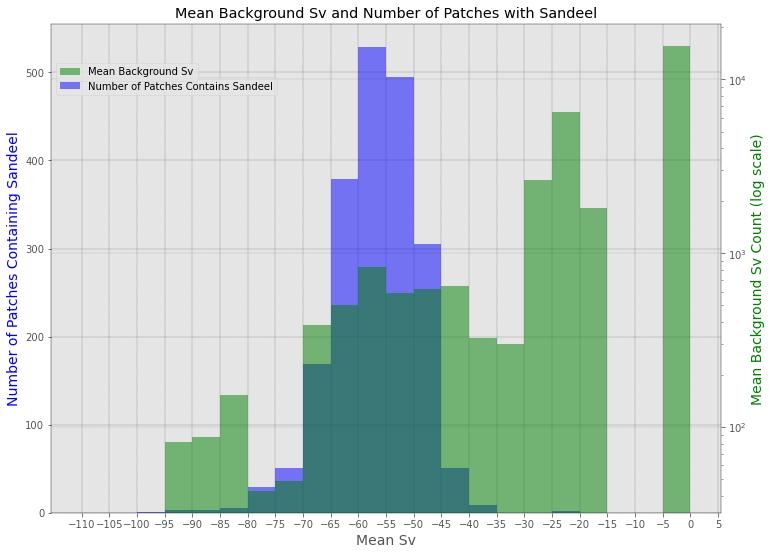

In [219]:
# Histogram of Mean Background Intensity and Number of Patches Containing Sandeel

thr_low = -110 # Lower threshold for Mean Sv Background
thr_up = 0 # Upper threshold for Mean Sv Background
fig_start = -110 # Starting Sv Value of Histogram
fig_finish = 5 # Ending Sv Value of Histogram
s_bin = 5 # Bin size of histogram

filt_bg = ((pdata['mean_background'].apply(lambda x: db(x))>thr_low) & 
           (pdata['mean_background'].apply(lambda x: db(x))<thr_up)) # Background Thresholding filter

fig,ax = plt.subplots(figsize = (12,9))
plt.rcParams["axes.linewidth"] = 0.2
plt.rcParams["axes.edgecolor"] = "black"
plt.title('Mean Background Sv and Number of Patches with Sandeel')
ax.hist(pdata[(pdata['nop_sandeel'] != 0) & filt_bg]
        ['mean_sandeel'].apply(lambda x: db(x)), bins = np.arange(fig_start, fig_finish, s_bin),
         label = 'Number of Patches Contains Sandeel', color='blue', alpha=0.5)

ax.set_xlabel("Mean Sv", fontsize = 14)
ax.set_ylabel("Number of Patches Containing Sandeel",
              color="blue",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
ax2=ax.twinx()
ax2.hist(pdata[filt_bg]['mean_background'].apply(lambda x: db(x)),
        bins = np.arange(fig_start, fig_finish, s_bin), 
        range = (thr_low, thr_up), alpha = 0.5, label = 'Mean Background Sv',
        color='green', log=True)
ax2.set_ylabel("Mean Background Sv Count (log scale)",
              color="green",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.93))
plt.xticks(np.arange(fig_start, fig_finish+1, s_bin))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.1)
plt.show()

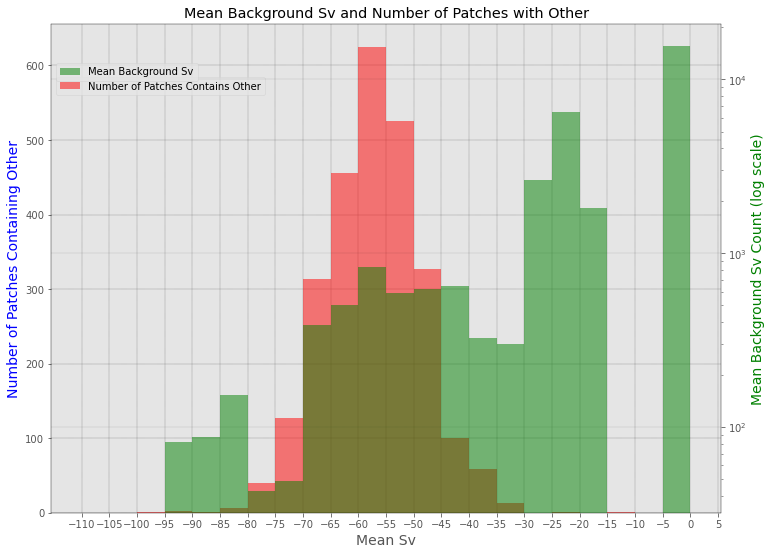

In [297]:
# Histogram of Mean Background Intensity and Number of Patches Containing Sandeel

filt_bg = ((pdata['mean_background'].apply(lambda x: db(x))>thr_low) & 
           (pdata['mean_background'].apply(lambda x: db(x))<thr_up)) # Background Thresholding filter

fig,ax = plt.subplots(figsize = (12,9))
plt.rcParams["axes.linewidth"] = 0.2
plt.rcParams["axes.edgecolor"] = "black"
plt.title('Mean Background Sv and Number of Patches with Other')
ax.hist(pdata[(pdata['nop_other'] != 0) & filt_bg]
        ['mean_other'].apply(lambda x: db(x)), bins = np.arange(fig_start, fig_finish, s_bin),
         label = 'Number of Patches Contains Other', color='red', alpha=0.5)
ax.set_xlabel("Mean Sv", fontsize = 14)
ax.set_ylabel("Number of Patches Containing Other",
              color="blue",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.9))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.2)
ax2=ax.twinx()
ax2.hist(pdata[filt_bg]['mean_background'].apply(lambda x: db(x)),
        bins = np.arange(fig_start, fig_finish, s_bin), 
        range = (thr_low, thr_up), alpha = 0.5, label = 'Mean Background Sv',
        color='green', log=True)
ax2.set_ylabel("Mean Background Sv Count (log scale)",
              color="green",
              fontsize=14)
plt.legend(loc='upper left', bbox_to_anchor=(0, 0.93))
plt.xticks(np.arange(fig_start, fig_finish+1, s_bin))
plt.grid(color = 'black', linestyle = '--', linewidth = 0.1)
plt.show()

# Example Ilustrations

mean background sv = 0.5103827  median background sv = 4.0332395e-08
mean background Sv = -2.921040447407553  median background Sv = -73.93270530446175


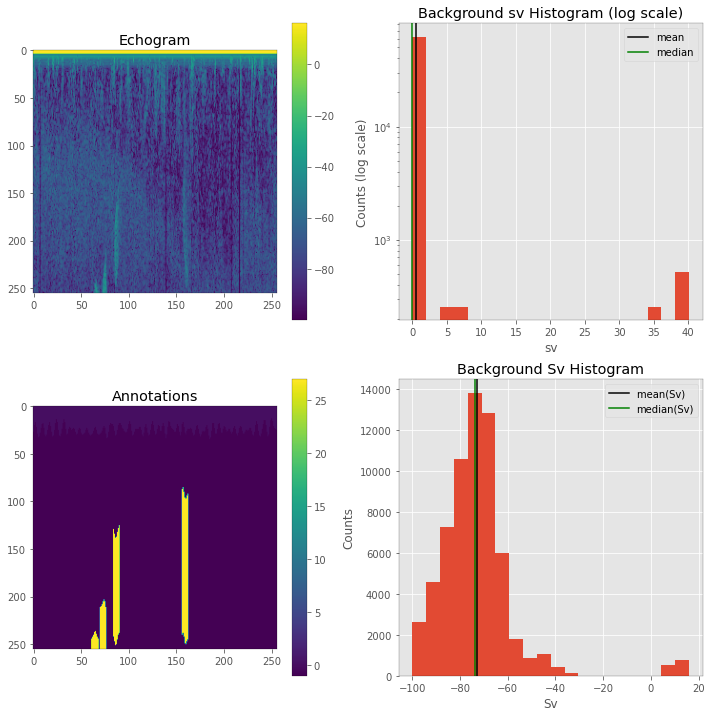

In [336]:
x, y = 46976, 128 

a = survey.get_data_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=False, frequencies=[38000])
c = survey.get_label_slice(idx_ping= x - patch_size[0] // 2, n_pings=patch_size[0],
                                        idx_range=int(y - patch_size[1] // 2), n_range=patch_size[1],
                                        return_numpy=True)

plt.figure(figsize = (12,12))
plt.subplot(2,2,1)
plt.title('Echogram')
plt.imshow(db(a[0,:,:].values.T))
plt.grid(None)
plt.colorbar()
plt.subplot(2,2,3)
plt.title('Annotations')
plt.imshow(c.T)
plt.grid(None)
plt.colorbar()

plt.subplot(2,2,2)
bg = a[0].values[np.logical_or(c==-1, c==0)]
plt.title('Background sv Histogram (log scale)')
plt.xlabel('sv')
plt.ylabel('Counts (log scale)')
plt.hist(bg, bins = 20, log = True)
plt.axvline(x=bg.mean(), color = 'black', label = 'mean')
plt.axvline(x=np.median(bg), color = 'green', label = 'median')
plt.legend()
print('mean background sv =', bg.mean(), ' median background sv =', np.median(bg))
print('mean background Sv =', db(bg.mean()), ' median background Sv =', db(np.median(bg)))

plt.subplot(2,2,4)
plt.hist(db(bg), bins = 20, log = False)
plt.axvline(x=db(bg).mean(), color = 'black', label = 'mean(Sv) ')
plt.axvline(x=np.median(db(bg)), color = 'green', label = 'median(Sv)')

#plt.axvline(x=db(bg.mean()), color = 'red', label = 'Sv(mean)')
#plt.axvline(x=db(np.median(bg)), color = 'blue', label = 'Sv(median)')

plt.title('Background Sv Histogram')
plt.xlabel('Sv')
plt.ylabel('Counts')
plt.legend()
plt.show()


# Summary Patch Information

In [383]:
sb = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Sandeel + Background
so = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Sandeel + Other
sp = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel
spo = len(pdata[(pdata['nop_sandeel'] >0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Sandeel + Possandeel + Other

ob = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']==0)]) # Other + Background
op = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']>0) & (pdata['nop_possandeel']>0)]) # Other + Possandeel
pb = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']>0)]) # Possandeel + Background

b = len(pdata[(pdata['nop_sandeel'] ==0) & (pdata['nop_other']==0) & (pdata['nop_possandeel']==0)]) # Possandeel + Background

In [393]:
b

27020